In [ ]:
%pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-posthocs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp

In [36]:
mpl.rcParams['axes.unicode_minus'] = False

current_os = platform.system()
if current_os == 'Windows':
    plt.rcParams["font.family"] = 'Malgun Gothic'
elif current_os == 'Darwin':
    plt.rcParams["font.family"] = 'AppleGothic'
else:
    plt.rcParams["font.family"] = 'NanumGothic'

In [37]:
data = pd.read_csv('../../data/school_health_preprocessed.csv')

df = data[['하루수면량', 'BMI', '성별', '학교급']].dropna()

sleep_time_mapping = {
    1.0: '6시간 이내',
    2.0: '6~7시간',
    3.0: '7~8시간',
    4.0: '8시간 이상'
}
df['수면시간대'] = df['하루수면량'].map(sleep_time_mapping)

df['수면시간_수치'] = df['하루수면량'].map({
    1.0: 5.5,   # 6시간 이내 평균 가정
    2.0: 6.5,   # 6~7시간 평균 가정
    3.0: 7.5,   # 7~8시간 평균 가정
    4.0: 8.5    # 8시간 이상 평균 가정
})

groups = df.groupby(['성별', '학교급'])

In [38]:
# 정규성 검정 - Shapiro-Wilk Test
## Shapiro-Wilk Test : 정규성 검정을 위한 테스트로 데이터 크기가 크지 않을 때 효과적이므로 사용함
for (gender, school_level), group in groups:
    stat_bmi, p_bmi = shapiro(group['BMI'])
    stat_sleep, p_sleep = shapiro(group['수면시간_수치'])
    print(f"{gender}, {school_level} - BMI: p-value={p_bmi}")
    print(f"{gender}, {school_level} - 수면시간: p-value={p_sleep}")
## 결과: 모든 그룹에서 정규 분포를 따르지 않음

남, 고 - BMI: p-value=5.685067869765783e-40
남, 고 - 수면시간: p-value=0.0
남, 중 - BMI: p-value=1.2611686178923354e-44
남, 중 - 수면시간: p-value=0.0
남, 초 - BMI: p-value=0.0
남, 초 - 수면시간: p-value=0.0
여, 고 - BMI: p-value=0.0
여, 고 - 수면시간: p-value=0.0
여, 중 - BMI: p-value=0.0
여, 중 - 수면시간: p-value=0.0
여, 초 - BMI: p-value=0.0
여, 초 - 수면시간: p-value=0.0


c:\Users\hooni\anaconda3\envs\sda2024\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [39]:
# 등분산성 검정 - Levene’s Test
# 그룹별 수면시간대
sleep_groups = df['수면시간_수치'].unique()
bmi_groups = [df[df['수면시간_수치'] == sleep]['BMI'] for sleep in sleep_groups]

stat_levene, p_levene = levene(*bmi_groups)
print(f"Levene’s test: p-value={p_levene}")
## 결과: 등분산성을 따르지 않음

Levene’s test: p-value=8.216084499033587e-45



=== 그룹별 잔차의 정규성 검정 ===
남, 고 - Shapiro-Wilk p-value: 5.4700806593690694e-40


c:\Users\hooni\anaconda3\envs\sda2024\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<Figure size 600x400 with 0 Axes>

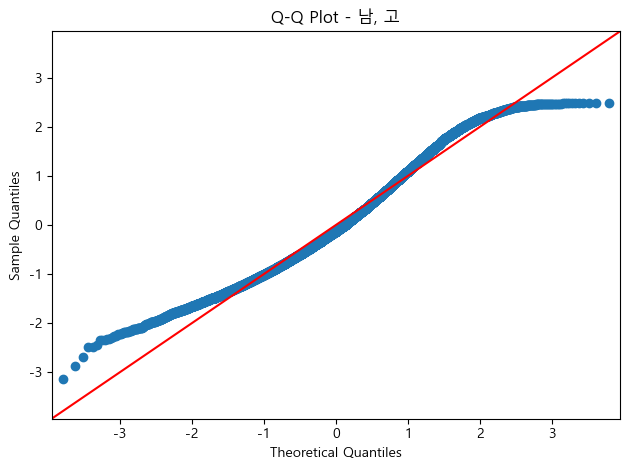

남, 중 - Shapiro-Wilk p-value: 9.80908925027372e-45


<Figure size 600x400 with 0 Axes>

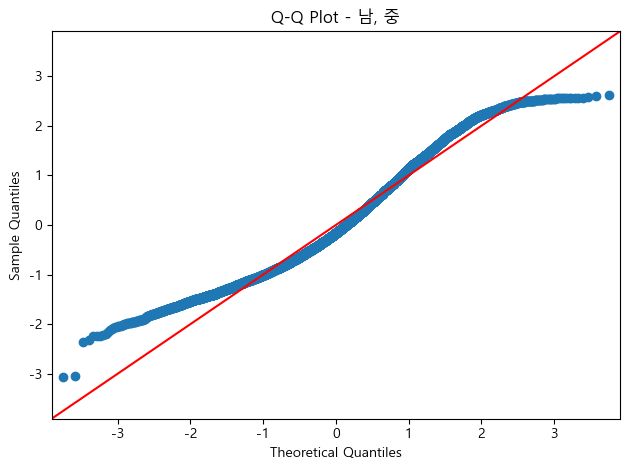

남, 초 - Shapiro-Wilk p-value: 0.0


<Figure size 600x400 with 0 Axes>

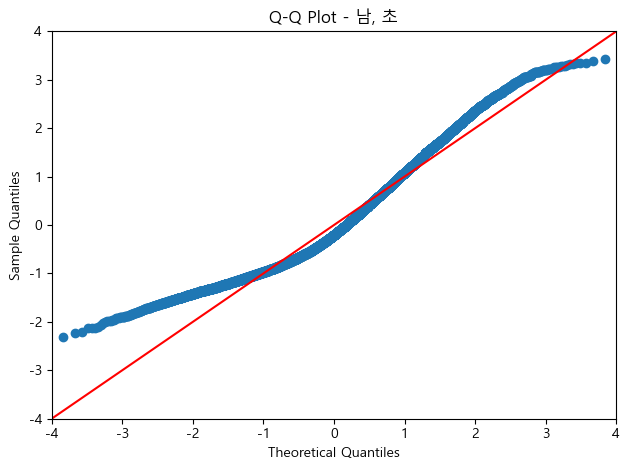

여, 고 - Shapiro-Wilk p-value: 0.0


<Figure size 600x400 with 0 Axes>

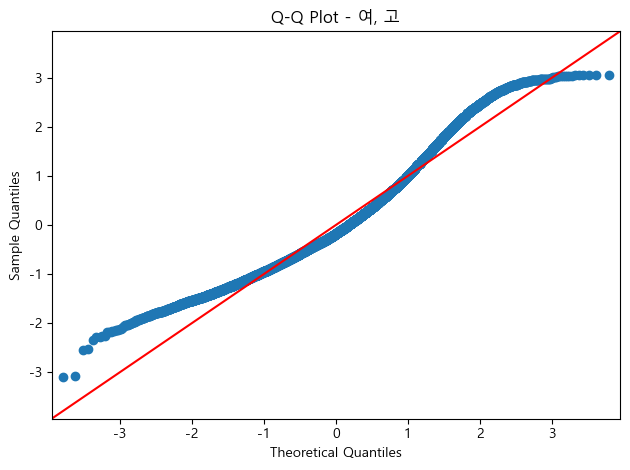

여, 중 - Shapiro-Wilk p-value: 0.0


<Figure size 600x400 with 0 Axes>

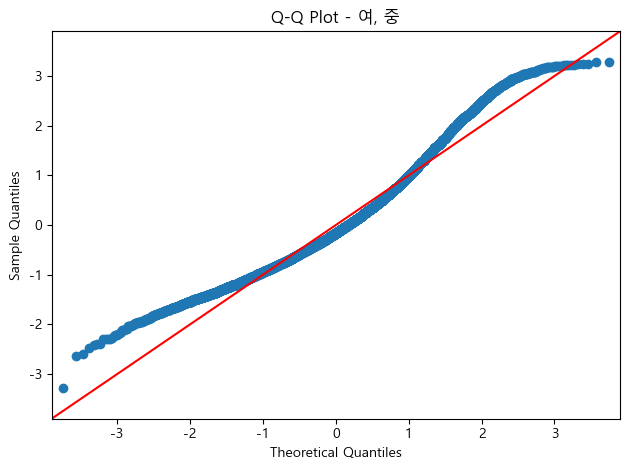

여, 초 - Shapiro-Wilk p-value: 0.0


<Figure size 600x400 with 0 Axes>

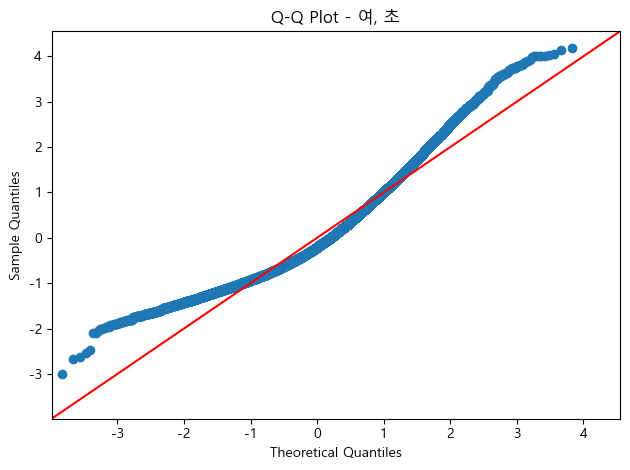

In [40]:
# 회귀 분석
model = ols('BMI ~ 수면시간_수치 + C(성별) + C(학교급) + 수면시간_수치:C(성별) + 수면시간_수치:C(학교급)', data=df).fit()

df['잔차'] = model.resid
df['예측값'] = model.fittedvalues

groups = df.groupby(['성별', '학교급'])

# 각 그룹별 잔차의 정규성 검정 및 QQ 플롯 생성
print("\n=== 그룹별 잔차의 정규성 검정 ===")
for (gender, school_level), group in groups:
    residuals = group['잔차']
    stat, p = shapiro(residuals)
    print(f"{gender}, {school_level} - Shapiro-Wilk p-value: {p}")
    
    # QQ 플롯
    plt.figure(figsize=(6, 4))
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f'Q-Q Plot - {gender}, {school_level}')
    plt.tight_layout()
    plt.show()
## 결과: 모든 그룹의 잔차가 정규성을 따르지 않음

In [41]:
## 정규성과 등분산성 모두 만족하지 않으므로 비모수 검정 진행
# Kruskal-Wallis : 학교급, 성별 그룹별로 범주형 변수인 수면시간대별로 연속형 변수인 BMI 사이의 차이를 비교하고자 사용함
grouped = df.groupby(['성별', '학교급'])

for (gender, school_level), group in grouped:
    groups = [group[group['수면시간대'] == sleep]['BMI'] for sleep in sleep_time_mapping.values()]
    sample_sizes = [len(g) for g in groups if len(g) > 0]

    stat, p = kruskal(*groups)
    k = len(groups) 
    N = sum(sample_sizes)

    # eta squared 계산(효과 크기 계산)
    if N > k:
        eta_squared = (stat - k + 1) / (N - k)
    else:
        eta_squared = None

    print(f"{gender}, {school_level} - Kruskal-Wallis p-value: {p}")
    if p < 0.05:
        print("-> 유의미한 차이가 있음")
    else:
        print("-> 유의미한 차이가 없음")

    if eta_squared is not None:
        print(f"Effect size (eta squared): {eta_squared:.4f}")
    else:
        print("Effect size (eta squared): 계산 불가 (N <= k)")
    print()
## 결과: 
# 모든 그룹에서 하루 수면량에 따른 BMI 차이가 유의미함
# 그러나, 남초, 여초 그룹을 제외한 모든 그룹에 대해서는 효과의 크기가 매우 작아 없다고 볼 수 있음 

남, 고 - Kruskal-Wallis p-value: 0.009367502040521334
-> 유의미한 차이가 있음
Effect size (eta squared): 0.0006

남, 중 - Kruskal-Wallis p-value: 0.0048371181330228085
-> 유의미한 차이가 있음
Effect size (eta squared): 0.0008

남, 초 - Kruskal-Wallis p-value: 5.30042648213453e-86
-> 유의미한 차이가 있음
Effect size (eta squared): 0.0236

여, 고 - Kruskal-Wallis p-value: 0.2591943105288919
-> 유의미한 차이가 없음
Effect size (eta squared): 0.0001

여, 중 - Kruskal-Wallis p-value: 0.0018282777480420967
-> 유의미한 차이가 있음
Effect size (eta squared): 0.0011

여, 초 - Kruskal-Wallis p-value: 1.8046179404301112e-109
-> 유의미한 차이가 있음
Effect size (eta squared): 0.0316



In [42]:
# Dunn's Test
## : Kruskal-Wallis 검정에서 유의미한 차이가 발견되어, 어떤 그룹 간에 차이가 있는지 탐색하기 위해 사용함
dunn_results = []

for (gender, school_level), group in grouped:
    groups = group['BMI']
    categories = group['수면시간대']
    if len(group['수면시간대'].unique()) < 2:
        print(f"{gender}, {school_level} - 그룹 내 수면시간대가 2개 미만으로 검정 불가")
        continue
    # 그룹 내 충분한 데이터가 있는지 확인
    if group.groupby('수면시간대').size().min() < 5:
        print(f"{gender}, {school_level} - 다중 비교를 위한 데이터 부족")
        continue
    try:
        dunn = sp.posthoc_dunn(group, val_col='BMI', group_col='수면시간대', p_adjust='bonferroni')
        significant = dunn.stack().reset_index()
        significant.columns = ['Group1', 'Group2', 'p-value']
        significant = significant[significant['p-value'] < 0.05]
        significant['Gender'] = gender
        significant['School_Level'] = school_level
        dunn_results.append(significant)
    except Exception as e:
        print(f"{gender}, {school_level} - Dunn's Test 수행 중 오류: {e}\n")

if dunn_results:
    dunn_results_df = pd.concat(dunn_results, ignore_index=True)
    print("Dunn's Test에서의 유의미한 결과 :")
    print(dunn_results_df)
else:
    print("유의미한 Dunn's Test 결과가 없습니다.")
## 결과: 
# 남, 고 그룹 - 8시간 이상 수면 그룹과 나머지 그룹은 유의미하게 BMI가 다름.
# 남, 중 그룹 - 8시간 이상 수면 그룹과 6~7시간, 6시간 이내 수면 그룹은 유의미하게 BMI가 다름.
# 남, 초 그룹 - 6시간 이내 수면 그룹과 7~8시간 수면 그룹을 제외한 모든 그룹에서 유의미하게 BMI가 다름.
# 여, 고 그룹 - 모든 그룹에서 유의미한 차이 없음.
# 여, 중 그룹 - 6시간 이내 - 7~8시간, 6시간 이내 - 8시간 이상 의 두 쌍에 대해서만 유의미한 차이를 발견함.
# 여, 초 그룹 - 6~7시간 수면 그룹과 6시간 이내 수면 그룹을 제외한 모든 그룹에서 유의미하게 BMI가 다름.

Dunn's Test에서의 유의미한 결과 :
    Group1  Group2       p-value Gender School_Level
0    6~7시간  8시간 이상  4.292263e-02      남            고
1   6시간 이내  8시간 이상  1.072342e-02      남            고
2    7~8시간  8시간 이상  8.866823e-03      남            고
3   8시간 이상   6~7시간  4.292263e-02      남            고
4   8시간 이상  6시간 이내  1.072342e-02      남            고
5   8시간 이상   7~8시간  8.866823e-03      남            고
6    6~7시간  8시간 이상  2.161933e-02      남            중
7   6시간 이내  8시간 이상  5.159877e-03      남            중
8   8시간 이상   6~7시간  2.161933e-02      남            중
9   8시간 이상  6시간 이내  5.159877e-03      남            중
10   6~7시간  6시간 이내  1.883709e-04      남            초
11   6~7시간   7~8시간  5.379247e-07      남            초
12   6~7시간  8시간 이상  7.747514e-50      남            초
13  6시간 이내   6~7시간  1.883709e-04      남            초
14  6시간 이내  8시간 이상  4.971516e-04      남            초
15   7~8시간   6~7시간  5.379247e-07      남            초
16   7~8시간  8시간 이상  8.101260e-58      남            초
17  8시간 이상   6~7시간  7

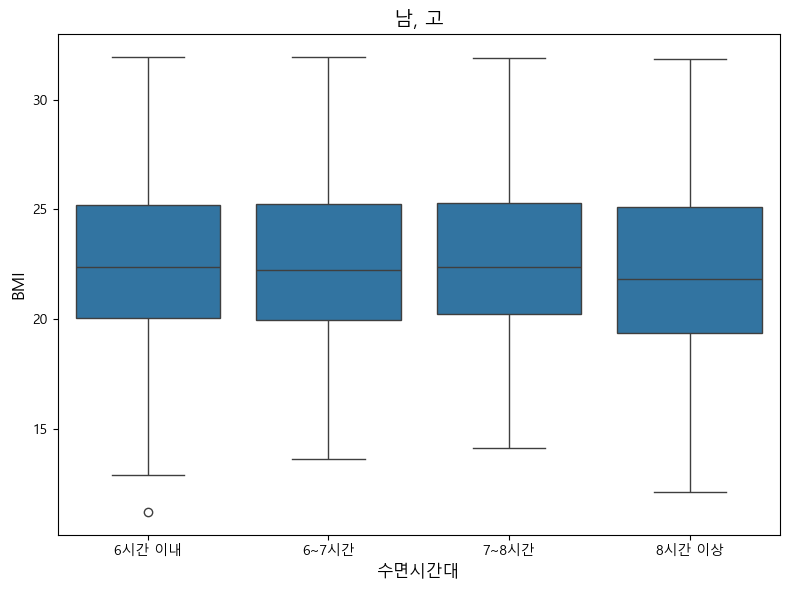

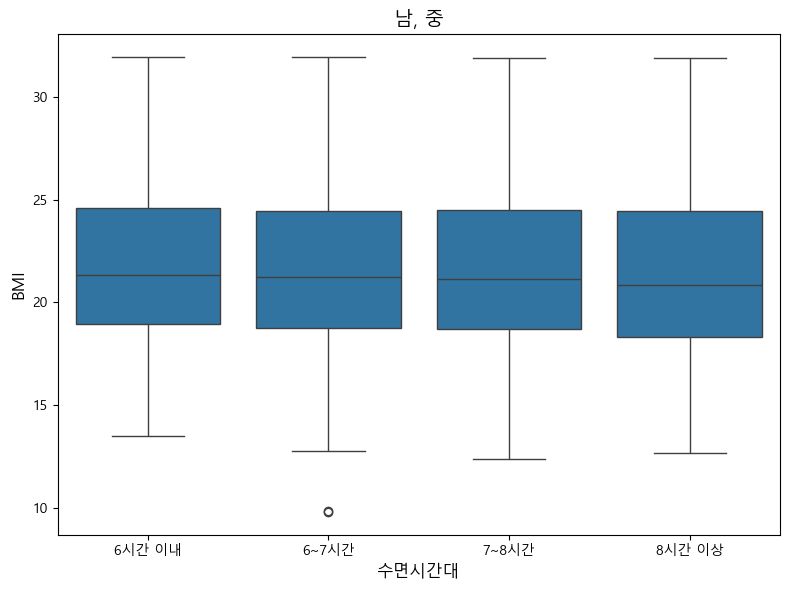

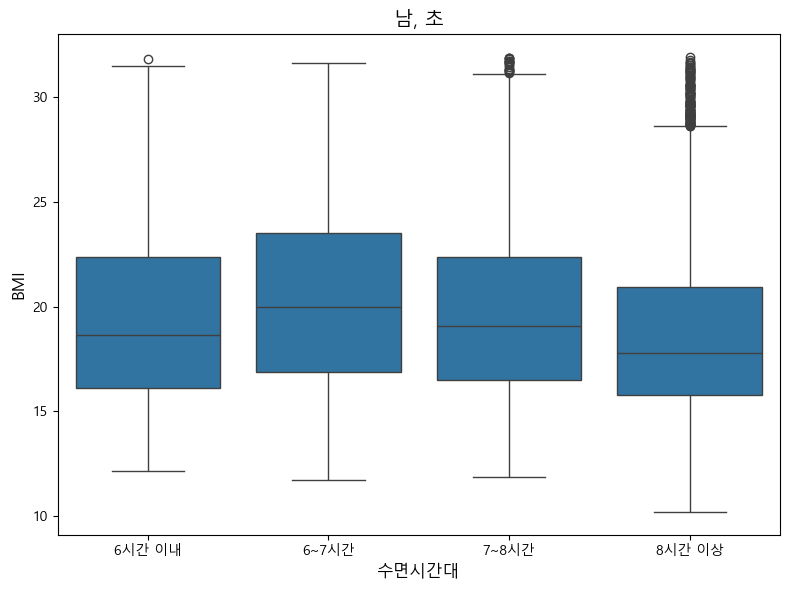

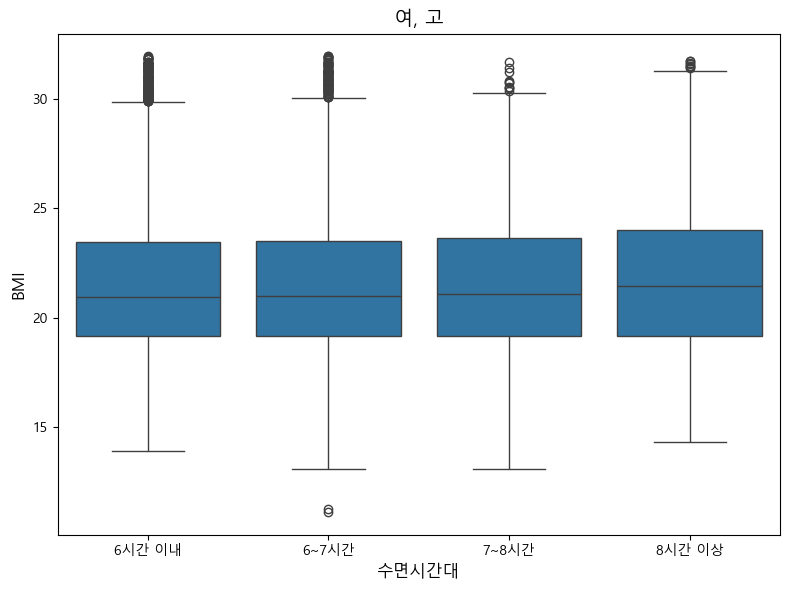

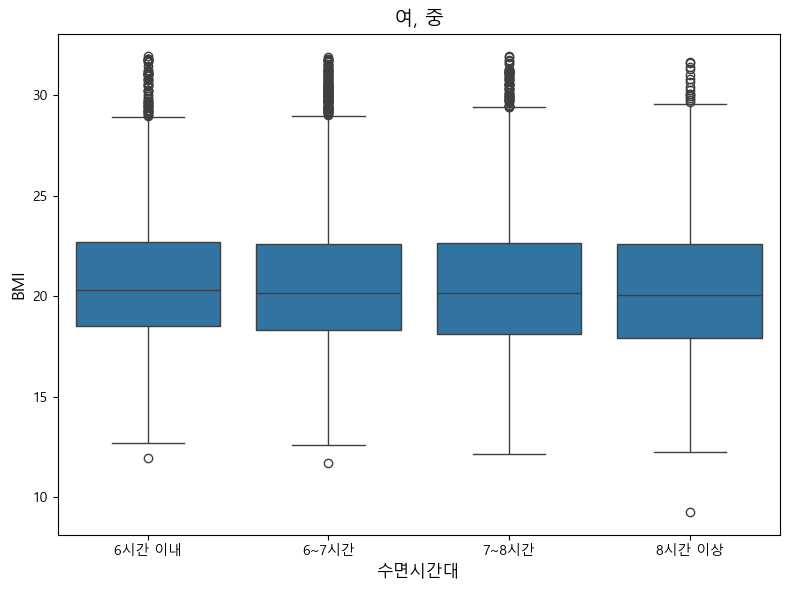

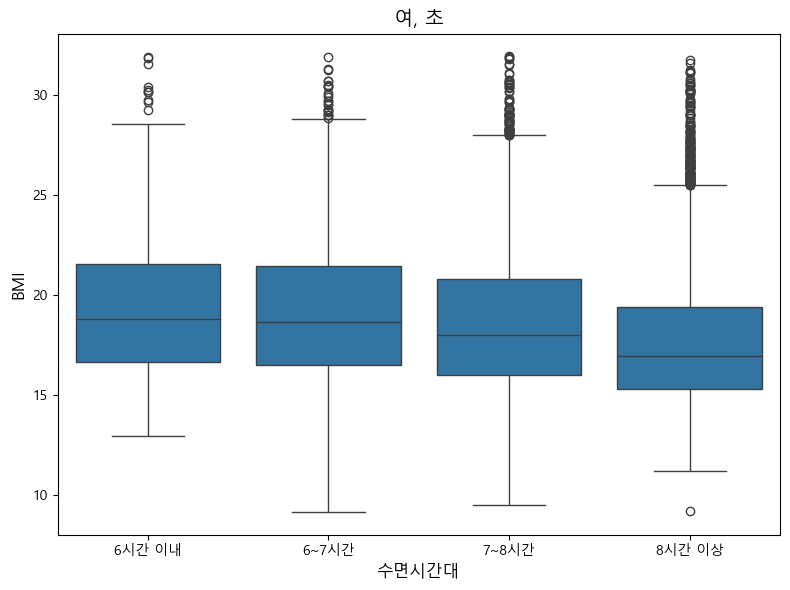

In [43]:
# Dunn's Test 결과를 바탕으로 시각화
sleep_time_order = ['6시간 이내', '6~7시간', '7~8시간', '8시간 이상']
school_level_order = ['초', '중', '고']
df['수면시간대'] = pd.Categorical(df['수면시간대'], categories=sleep_time_order, ordered=True)
df['학교급'] = pd.Categorical(df['학교급'], categories=school_level_order, ordered=True)

for (gender, school_level), group in grouped:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=group, x='수면시간대', y='BMI')
    plt.title(f'{gender}, {school_level}', fontsize=14)
    plt.xlabel('수면시간대', fontsize=12)
    plt.ylabel('BMI', fontsize=12)
    plt.tight_layout()
    plt.show()
## 결과: 
# 남, 고 그룹 - 8시간 이상 수면 그룹과 나머지 그룹에 비해 유의미하게 BMI가 낮음.
# 남, 중 그룹 - 8시간 이상 수면 그룹과 6~7시간, 6시간 이내 수면 그룹에 비해 유의미하게 BMI가 낮음.
# 남, 초 그룹 - 6시간 이내 수면 그룹은 유의미하게 BMI가 낮고, 나머지 그룹에 대해서는 수면 시간이 길수록 BMI가 낮음.
# 여, 고 그룹 - 모든 그룹에서 유의미한 차이 없음.
# 여, 중 그룹 - 대부분 그룹에서 유의미한 차이 없음.
# 여, 초 그룹 - 수면 시간이 길수록 유의미하게 BMI가 낮음.